## Analysis ODI Cricket Matches (2001-2020)

In [1]:
#Importing useful libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load Data

matches = pd.read_csv("data/Men ODI Team Match Results - 21st Century.csv")
matches.head(2)

,Result,Margin,Match,Home/Away,Ground,Match Date,Match Month,Match Year,Match Period,Matches,Country
0,Lost,5 wickets,Sri Lanka v England,Away,Dambulla,2001/03/23,Mar,2001,Mar 2001,1,England
1,Lost,66 runs,Sri Lanka v England,Away,Colombo (RPS),2001/03/25,Mar,2001,Mar 2001,1,England


In [3]:
# Shape and Datatypes

matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5170 entries, 0 to 5169
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Result        5170 non-null   object
 1   Margin        5163 non-null   object
 2   Match         5170 non-null   object
 3   Home/Away     5170 non-null   object
 4   Ground        5170 non-null   object
 5   Match Date    5170 non-null   object
 6   Match Month   5170 non-null   object
 7   Match Year    5170 non-null   int64 
 8   Match Period  5170 non-null   object
 9   Matches       5170 non-null   int64 
 10  Country       5170 non-null   object
dtypes: int64(2), object(9)
memory usage: 444.4+ KB


In [4]:
# Missing Values

matches.isna().sum()

Result          0
Margin          7
Match           0
Home/Away       0
Ground          0
Match Date      0
Match Month     0
Match Year      0
Match Period    0
Matches         0
Country         0
dtype: int64

In [5]:
matches['Margin'].value_counts(dropna=False)[0:10]

Margin
-            444
7 wickets    439
6 wickets    425
5 wickets    302
8 wickets    302
4 wickets    270
3 wickets    205
9 wickets    162
2 wickets    123
1 wickets     85
Name: count, dtype: int64

It can be clearly seen that the margin column not only has Nans in it but it also has 444 "-" values , All these matches where the Margin is set to "-" indicate instances where the match did not take place and was either canceled or abandoned. Therefore, we can confidently exclude these rows from the dataset as they do not provide valuable information for our analysis.

In [6]:
# Removing the rows where  Data from the Dataset

matches.dropna(inplace=True) # Treating Missing values
df_margin = matches[(matches['Result']== 'Won' ) | (matches['Result'] == 'Lost')].copy()
df_margin.head(3)


,Result,Margin,Match,Home/Away,Ground,Match Date,Match Month,Match Year,Match Period,Matches,Country
0,Lost,5 wickets,Sri Lanka v England,Away,Dambulla,2001/03/23,Mar,2001,Mar 2001,1,England
1,Lost,66 runs,Sri Lanka v England,Away,Colombo (RPS),2001/03/25,Mar,2001,Mar 2001,1,England
2,Lost,10 wickets,Sri Lanka v England,Away,Colombo (SSC),2001/03/27,Mar,2001,Mar 2001,1,England


I've created another dataset with the name df_margin because we will still need our complete dataset with all the Result types like Abondaned, cancelled, etc. for our analysis.

### Exploratory Data Analysis

###### What is the distribution of match results (Win/Loss/Tied/NR) in the dataset?

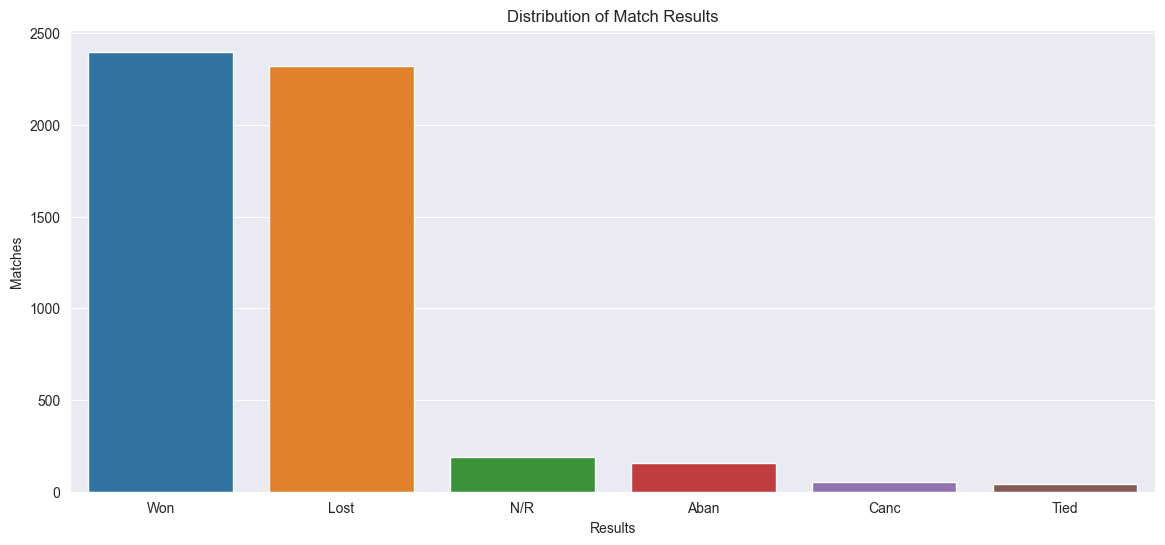

In [7]:
results = matches['Result'].value_counts().reset_index(name="matches")

plt.figure(figsize=(14,6))
sns.set_style("darkgrid")
sns.barplot(x='Result',y='matches',data=results)
plt.title("Distribution of Match Results")
plt.xlabel("Results")
plt.ylabel("Matches")
plt.show()

###### Find any patterns in margins of victory/defeat? Are Easy wins more common than close matches?

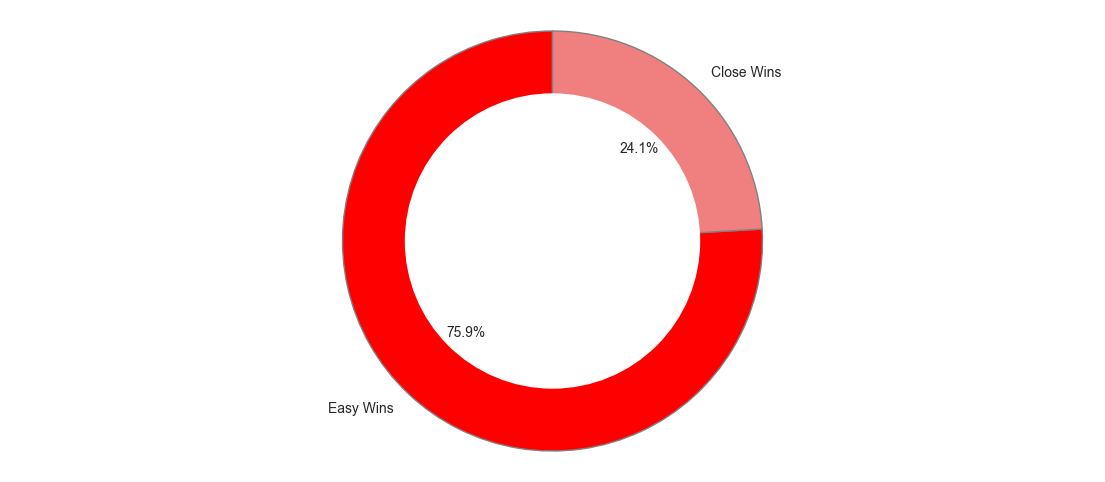

In [8]:
# Creating a Margin Value and Margin Unit column 

df_margin[['Margin_Value','Margin_Unit']] = df_margin['Margin'].str.extract(r'(\d+)\s*(\w+)')

df_margin['Margin_Value'] = pd.to_numeric(df_margin['Margin_Value'])

# Function to Categorize matches based on margin and units (Runs / Wickets)

def categorize_margin(row):
    
    threshold_runs = 20
    threshold_wickets = 4
    
    if row['Margin_Unit'] == 'runs':
        if row['Margin_Value'] <= threshold_runs:
            return "Close Win"
        elif row['Margin_Value'] > threshold_runs:
            return "Easy Win"
    elif row['Margin_Unit'] == 'wickets':
        if row['Margin_Value'] <= threshold_wickets:
            return "Close Win"
        elif row['Margin_Value'] > threshold_wickets:
            return "Easy Win"
    else:
        return "other"

# Creating Margin Category

df_margin['Margin_Category'] = df_margin.apply(categorize_margin,axis=1)

# Plotting a Donut chart for the Win/Loss Margin Distribution

fig, ax = plt.subplots(figsize=(14, 6))
colors = ['red', 'lightcoral']
explode = (0.1, 0)  # Explode the first slice

wedges, texts, autotexts = ax.pie(df_margin['Margin_Category'].value_counts().values, labels=['Easy Wins','Close Wins'],
                                   autopct='%1.1f%%', startangle=90,
                                   colors=colors, wedgeprops={'edgecolor': 'gray'})

# Draw circle in the center for a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='White')
fig.gca().add_artist(centre_circle)

ax.axis('equal')
plt.show()


###### How do match outcomes differ between home and away games?

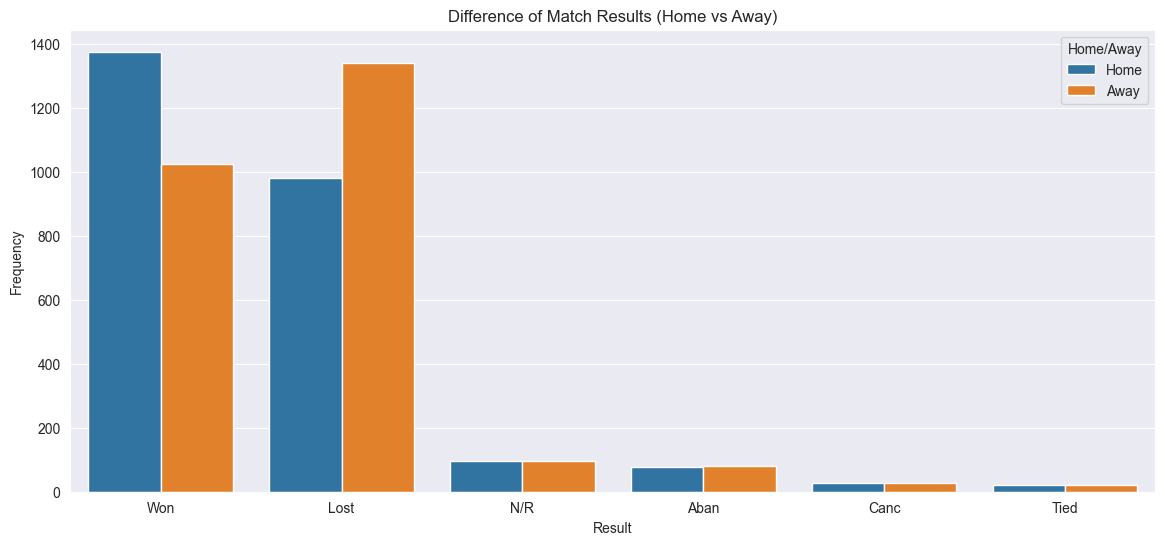

In [9]:
outcomes = matches[['Result','Home/Away']].value_counts().reset_index(name='Frequency')

plt.figure(figsize=(14,6))
sns.set_style('darkgrid')
sns.barplot(x=outcomes['Result'],y=outcomes['Frequency'],hue=outcomes['Home/Away'])
plt.title("Difference of Match Results (Home vs Away)")
plt.show()

###### Which grounds have hosted the most matches?

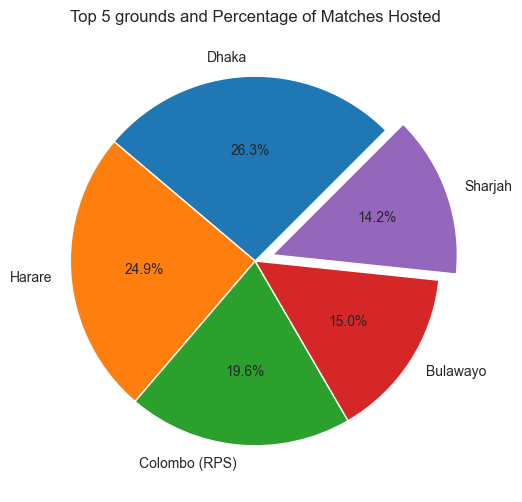

In [10]:
ground_match_counts = matches.groupby('Ground')['Match'].count().reset_index().sort_values(by="Match",ascending=False)
top_5_grounds = ground_match_counts.head(5)

plt.figure(figsize=(14,6))
plt.pie(top_5_grounds['Match'],labels = ['Dhaka','Harare','Colombo (RPS)','Bulawayo','Sharjah'],autopct="%1.1f%%",startangle=45,explode=[0,0,0,0,0.1])
plt.title("Top 5 grounds and Percentage of Matches Hosted")
plt.show()

###### Is there a correlation between a team's performance and the ground?

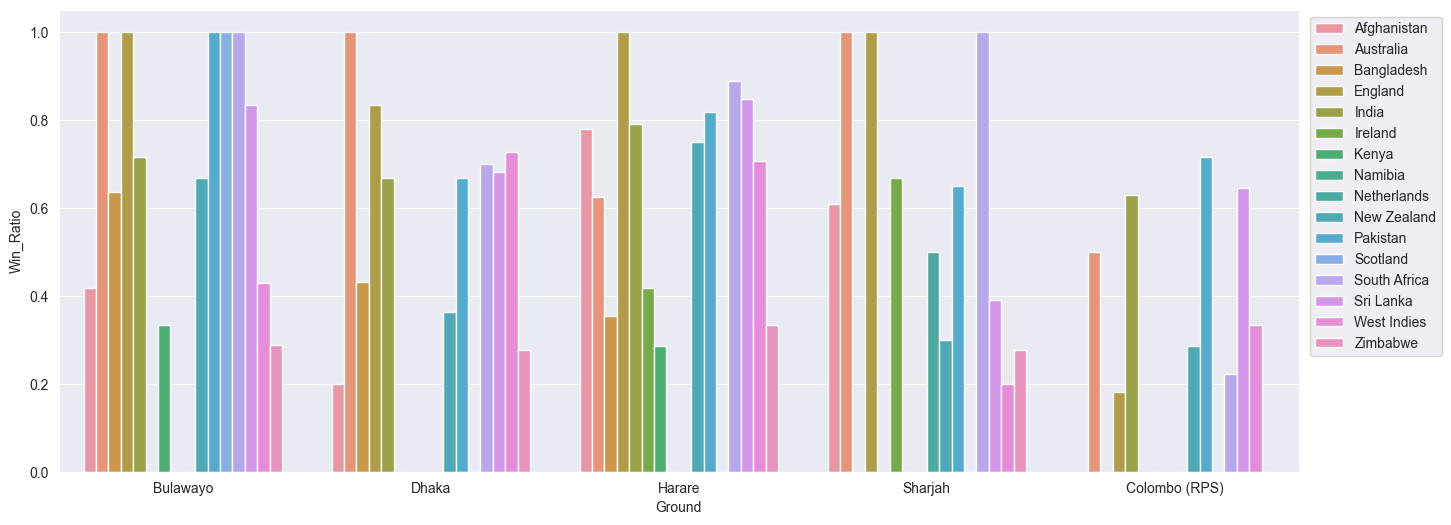

In [11]:
top_grounds = matches[(matches['Ground'] == 'Dhaka') | (matches['Ground'] == 'Harare') | (matches['Ground'] == 'Colombo (RPS)') | (matches['Ground'] == 'Bulawayo') | (matches['Ground'] == 'Sharjah')]

team_performance = top_grounds.groupby(['Country','Ground','Result'])['Result'].count().unstack(fill_value=0).reset_index()
team_performance['Win_Ratio'] = team_performance['Won'] / (team_performance['Won']+team_performance['Lost'])

plt.figure(figsize=(16,6))
sns.barplot(y=team_performance['Win_Ratio'],x=team_performance['Ground'],hue=team_performance['Country'])
plt.legend(bbox_to_anchor=(1.121,1),loc="upper right")
plt.show()

###### What is the average number of matches played per country? Are there countries with a higher frequency of matches?

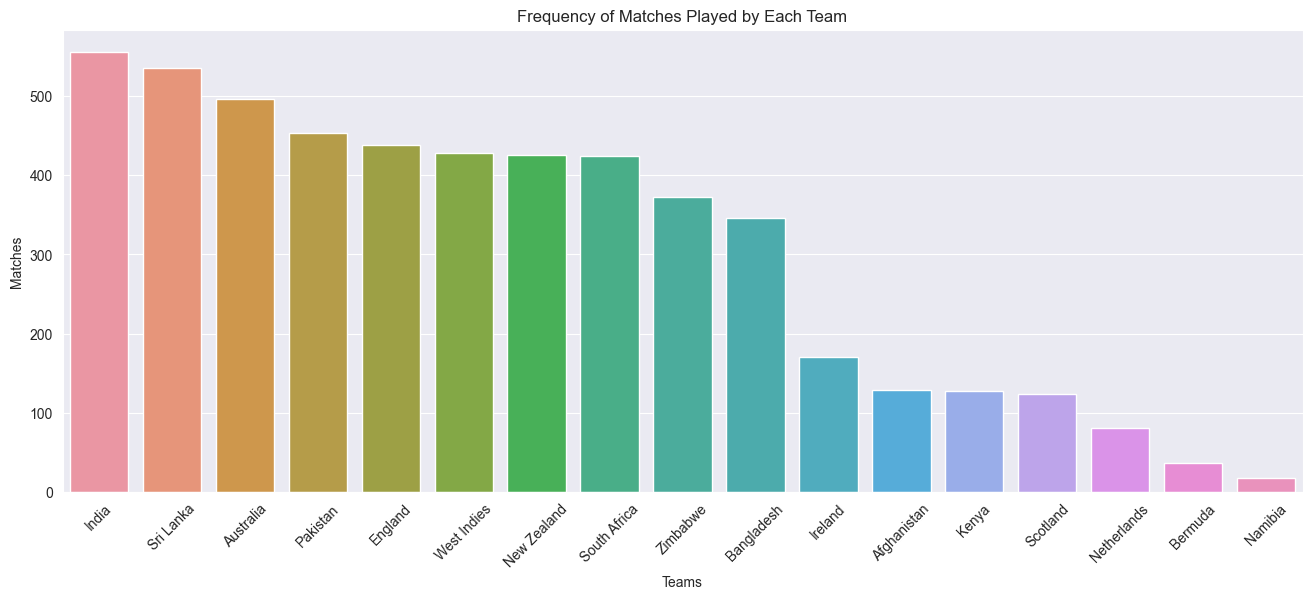

In [12]:
match_played = matches.groupby(['Country'])['Home/Away'].count().reset_index(name="matches played").sort_values(by="matches played",ascending=False)

plt.figure(figsize=(16,6))
sns.barplot(x="Country",y="matches played",data=match_played)
plt.xlabel("Teams")
plt.ylabel("Matches")
plt.title("Frequency of Matches Played by Each Team")
plt.xticks(rotation=45)
plt.show()

###### Are there any countries that consistently perform better in away matches

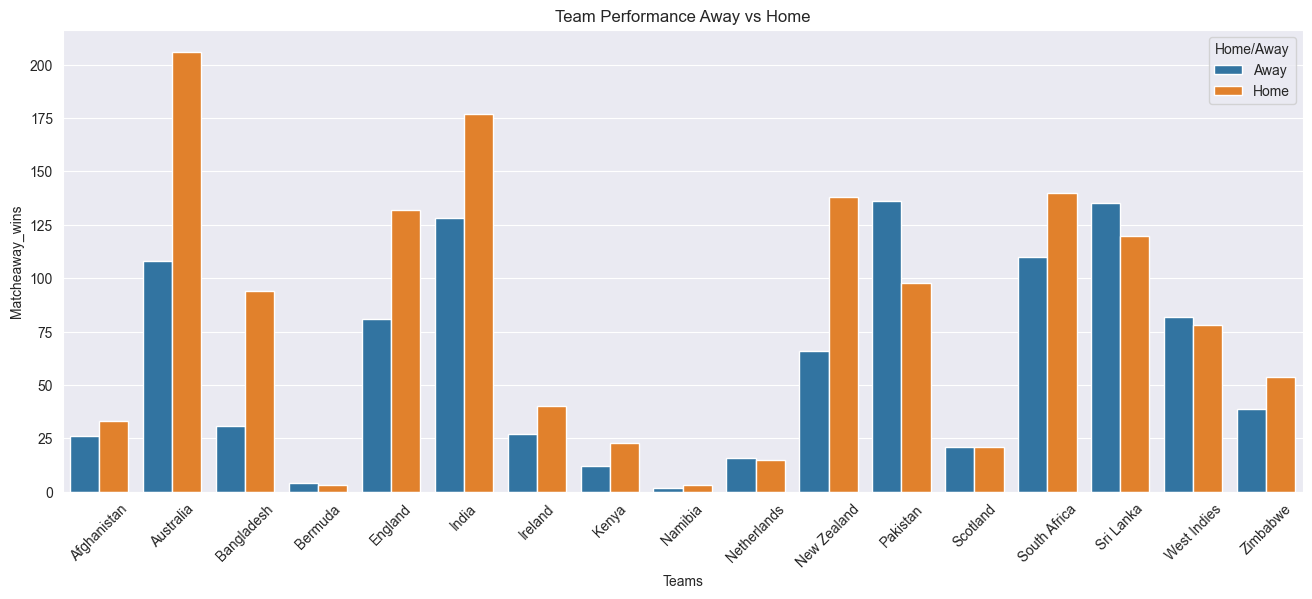

In [13]:
away_win = matches.groupby(['Country','Home/Away','Result']).agg({'Match':'count'}).reset_index()

away_win = away_win[away_win['Result']=='Won'].sort_values(by='Country',ascending=True)

plt.figure(figsize=(16,6))
sns.barplot(x=away_win['Country'],y=away_win['Match'],hue=away_win['Home/Away'])
plt.xlabel("Teams")
plt.ylabel("Matcheaway_wins")
plt.title("Team Performance Away vs Home")
plt.xticks(rotation=45)
plt.show()

Well, not surprising at all to see pakistan in the top 3 countries who have performed well in away matche,because Pakistan has been playing cricket away from home since 2009 till 2015 when finally cricket came back to pakistan.